In [74]:
%matplotlib inline
import openmc
import os

from dotenv import load_dotenv

load_dotenv()

CROSS_SECTIONS = os.getenv('CROSS_SECTIONS')
CHAIN_FILE = os.getenv('CHAIN_FILE')

openmc.config['cross_sections'] = CROSS_SECTIONS
openmc.config['chain_file'] = CHAIN_FILE

In [75]:
# Materials definitions

spent_fuel = openmc.Material(name='Fuel')
spent_fuel.add_nuclide('U235', 0.05) 
spent_fuel.add_nuclide('Pu239', 0.03)
spent_fuel.add_nuclide('U238', 0.92)
spent_fuel.set_density('g/cm3', 10.0)

zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

graphite = openmc.Material(name='Graphite')
graphite.set_density('g/cm3', 1.85)
graphite.add_element('C', 1)

steel = openmc.Material(name='Stainless Steel')
steel.set_density('g/cm3', 8.00)
steel.add_element('C', 0.08, percent_type='wo')
steel.add_element('Si', 1.00, percent_type='wo')
steel.add_element('Mn', 2.00, percent_type='wo')
steel.add_element('P', 0.045, percent_type='wo')
steel.add_element('S', 0.030, percent_type='wo')
steel.add_element('Cr', 20.0, percent_type='wo')
steel.add_element('Ni', 11.0, percent_type='wo')
steel.add_element('Fe', 65.845, percent_type='wo')

helium = openmc.Material(name='Helium')
helium.set_density('g/cm3', 0.1786)
helium.add_element('He', 3)

# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([spent_fuel, helium, zircaloy, graphite, steel])
materials_file.export_to_xml()

In [76]:
# Geometry definitions

In [77]:
bottom = openmc.ZPlane(z0=-1.0, boundary_type = 'reflective')
top = openmc.ZPlane(z0=1.0, boundary_type = 'reflective')

In [78]:
pitch = 1.6256

# Create the x and y planes that define the boundaries of the square
x_min = openmc.XPlane(x0=-pitch / 2)
x_max = openmc.XPlane(x0=pitch / 2)
y_min = openmc.YPlane(y0=-pitch / 2)
y_max = openmc.YPlane(y0=pitch / 2)

# Create a region from the intersection of the planes
pin_cell_box = +x_min & -x_max & +y_min & -y_max 

In [79]:
# Geometry definitions for the fuel rod

fuel_or  = openmc.ZCylinder(r=1.0414/2, name='Fuel OR')
fclad_ir = openmc.ZCylinder(r=1.06426/2, name='Clad IR')
fclad_or = openmc.ZCylinder(r=1.22682/2, name='Clad OR')
graphite_ir = openmc.ZCylinder(r=1.3)
graphite_or = openmc.ZCylinder(r=1.5)

fuel_region = -fuel_or 
gap_region  = +fuel_or & -fclad_ir
fclad_region  = +fclad_ir & -fclad_or
graphite_region = +fclad_or & -graphite_ir
fhelium_region = +graphite_or & pin_cell_box

fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = spent_fuel
fuel_cell.region = fuel_region 

gap_cell = openmc.Cell(name='air gap')
gap_cell.region = gap_region

clad_cell = openmc.Cell(name='clad')
clad_cell.fill = zircaloy
clad_cell.region = fclad_region

graphite_cell = openmc.Cell(name='graphite')
graphite_cell.fill = graphite
graphite_cell.region = graphite_region

fhelium_cell = openmc.Cell(name='fhelium')
fhelium_cell.fill = helium
fhelium_cell.region = fhelium_region

fuel_pin_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, graphite_cell, fhelium_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

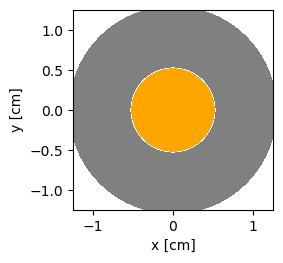

In [80]:
fuel_pin_universe.plot(width=(2.5, 2.5), colors={fuel_cell: 'orange', gap_cell: 'white', clad_cell: 'grey', graphite_cell: 'gray', fhelium_cell: 'blue'})

In [81]:
# Geometry definitions for the helium rod

helium_or = openmc.ZCylinder(r=1.34874/2)
wclad_or = openmc.ZCylinder(r=1.50114/2)

whelium_inner_region = -helium_or
wclad_region = -wclad_or & +helium_or 
whelium_outer_region = pin_cell_box & +wclad_or

whelium_inner_cell = openmc.Cell(name='whelium_inner')
whelium_inner_cell.region = whelium_inner_region
whelium_inner_cell.fill = helium

wclad_cell = openmc.Cell(name='wclad')
wclad_cell.fill = zircaloy
wclad_cell.region = wclad_region 

whelium_outer_cell = openmc.Cell(name='whelium_outer')
whelium_outer_cell.fill = helium
whelium_outer_cell.region = whelium_outer_region

helium_pin_universe = openmc.Universe(cells=[whelium_inner_cell, wclad_cell, whelium_outer_cell])

In [82]:
# Geometry definitions for the corner rod

corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name = 'Corner Cell: Fuel OR')
corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name = 'Corner Cell: Clad IR')
corner_clad_or = openmc.ZCylinder(r=1.22682/2, name = 'Corner Cell: Clad OR')
graphite_ir = openmc.ZCylinder(r=1.3)
graphite_or = openmc.ZCylinder(r=1.5)

corner_fuel_cell = openmc.Cell(name='fuel')
corner_fuel_cell.fill = spent_fuel
corner_fuel_cell.region = -corner_fuel_or 

corner_gap_cell = openmc.Cell(name='air gap')
corner_gap_cell.region = -corner_clad_ir & +corner_fuel_or

corner_clad_cell = openmc.Cell(name='clad')
corner_clad_cell.fill = zircaloy
corner_clad_cell.region = +corner_clad_ir & -corner_clad_or

graphite_cell = openmc.Cell(name='graphite')
graphite_cell.fill = graphite
graphite_cell.region = +corner_clad_or & -graphite_ir

helium_cell = openmc.Cell(name='helium')
helium_cell.fill = helium
helium_cell.region = +graphite_or & pin_cell_box

corner_pin_universe = openmc.Universe(cells=[corner_fuel_cell, corner_gap_cell, corner_clad_cell, graphite_cell, helium_cell])

In [83]:
# Defining an Assembly

In [84]:
margin = 1e-8
sleave_thickness = 0.2032
sleave_inner_radius = 0.9652 + margin

In [85]:
ur_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='ur Corner Cell: Fuel OR')
ur_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='ur Corner Cell: Clad IR')
ur_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='ur Corner Cell: Clad OR')
graphite_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius)
graphite_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius + sleave_thickness)

ur_corner_fuel_cell = openmc.Cell(name='ur fuel')
ur_corner_fuel_cell.fill = spent_fuel
ur_corner_fuel_cell.region = -ur_corner_fuel_or 

ur_corner_gap_cell = openmc.Cell(name='ul air gap')
ur_corner_gap_cell.region = -ur_corner_clad_ir & +ur_corner_fuel_or

ur_corner_clad_cell = openmc.Cell(name='ul clad')
ur_corner_clad_cell.fill = zircaloy
ur_corner_clad_cell.region = +ur_corner_clad_ir & -ur_corner_clad_or

ur_sleave_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius)
ur_sleave_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius + sleave_thickness)

ur_sleave_hor_bound = openmc.XPlane(x0=pitch/2 - sleave_inner_radius - margin)
ur_sleave_ver_bound = openmc.YPlane(y0=pitch/2 - sleave_inner_radius + margin)

ur_sleave_cell = openmc.Cell(name='ur sleave cell')
ur_sleave_cell.region = -ur_sleave_or & +ur_sleave_ir & +ur_sleave_hor_bound & +ur_sleave_ver_bound & pin_cell_box
ur_sleave_cell.fill = zircaloy

ur_sleave_helium_cell = openmc.Cell(name = 'ur sleave helium')
ur_sleave_helium_cell.region = pin_cell_box & +ur_sleave_hor_bound & +ur_sleave_ver_bound & +ur_sleave_or
ur_sleave_helium_cell.fill = helium

ur_sleave_ver_helium_cell = openmc.Cell(name='ur vertically-equivalent sleave helium')
ur_sleave_ver_helium_cell.region = pin_cell_box & -ur_sleave_hor_bound & +ur_sleave_ver_bound & +ur_sleave_ir
ur_sleave_ver_helium_cell.fill = helium 

ur_opposite_helium_cell = openmc.Cell(name='ur opposite helium')
ur_opposite_helium_cell.region = pin_cell_box & -ur_sleave_hor_bound & -ur_sleave_ver_bound & +ur_sleave_ir
ur_opposite_helium_cell.fill = helium 

ur_sleave_hor_helium_cell = openmc.Cell(name='ur horizontally-equivalent sleave helium')
ur_sleave_hor_helium_cell.region = pin_cell_box & +ur_sleave_hor_bound & -ur_sleave_ver_bound & +ur_sleave_ir
ur_sleave_hor_helium_cell.fill = helium 

ur_inner_helium_cell = openmc.Cell(name='ur inner helium cell')
ur_inner_helium_cell.region = pin_cell_box & -ur_sleave_ir & +ur_corner_clad_or
ur_inner_helium_cell.fill = helium

graphite_cell = openmc.Cell(name='graphite')
graphite_cell.fill = graphite
graphite_cell.region = +ur_corner_clad_or & -graphite_ir

ur_corner_pin_universe = openmc.Universe(cells=[ur_corner_fuel_cell, ur_corner_gap_cell, ur_corner_clad_cell, graphite_cell, ur_inner_helium_cell, ur_sleave_helium_cell, ur_sleave_ver_helium_cell, ur_opposite_helium_cell, ur_sleave_hor_helium_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

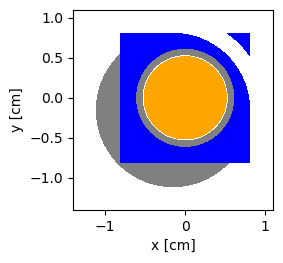

In [86]:
ur_corner_pin_universe.plot(width=(2.5, 2.5), basis='xy', colors={
    ur_corner_fuel_cell: 'orange', 
    ur_corner_gap_cell: 'white', 
    ur_corner_clad_cell: 'grey', 
    ur_sleave_cell: 'brown', 
    ur_inner_helium_cell: 'blue', 
    ur_sleave_helium_cell: 'blue', 
    ur_sleave_ver_helium_cell: 'blue', 
    ur_opposite_helium_cell: 'blue', 
    ur_sleave_hor_helium_cell: 'blue', 
    graphite_cell: 'gray'
})

In [87]:
ul_corner_fuel_or = openmc.ZCylinder(r=(1.0414/2), name='ul Corner Cell: Fuel OR')
ul_corner_clad_ir = openmc.ZCylinder(r=(1.06426/2), name='ul Corner Cell: Clad IR')
ul_corner_clad_or = openmc.ZCylinder(r=(1.22682/2), name='ul Corner Cell: Clad OR')

ul_corner_fuel_cell = openmc.Cell(name='ul fuel')
ul_corner_fuel_cell.fill = spent_fuel
ul_corner_fuel_cell.region = -ul_corner_fuel_or 

ul_corner_gap_cell = openmc.Cell(name='ul air gap')
ul_corner_gap_cell.region = -ul_corner_clad_ir & +ul_corner_fuel_or

ul_corner_clad_cell = openmc.Cell(name='ul clad')
ul_corner_clad_cell.fill = zircaloy
ul_corner_clad_cell.region = +ul_corner_clad_ir & -ul_corner_clad_or

ul_sleave_ir = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius) #Shouldn't have margin
ul_sleave_or = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius + sleave_thickness)

ul_sleave_hor_bound = openmc.XPlane(x0=-pitch/2+sleave_inner_radius+margin)
ul_sleave_ver_bound = openmc.YPlane(y0=pitch/2-sleave_inner_radius+margin)

ul_sleave_cell = openmc.Cell(name='ul sleave cell')
ul_sleave_cell.region = -ul_sleave_or & +ul_sleave_ir & -ul_sleave_hor_bound & +ul_sleave_ver_bound & pin_cell_box
ul_sleave_cell.fill = zircaloy

ul_sleave_helium_cell = openmc.Cell(name='ul sleave helium')
ul_sleave_helium_cell.region = pin_cell_box & -ul_sleave_hor_bound & +ul_sleave_ver_bound & +ul_sleave_or
ul_sleave_helium_cell.fill = helium

ul_sleave_ver_helium_cell = openmc.Cell(name='ul vertically-equivalent sleave helium')
ul_sleave_ver_helium_cell.region = pin_cell_box & +ul_sleave_hor_bound & +ul_sleave_ver_bound & +ul_sleave_ir
ul_sleave_ver_helium_cell.fill = helium 

ul_opposite_helium_cell = openmc.Cell(name='ul opposite helium')
ul_opposite_helium_cell.region = pin_cell_box & +ul_sleave_hor_bound & -ul_sleave_ver_bound & +ul_sleave_ir
ul_opposite_helium_cell.fill = helium 

ul_sleave_hor_helium_cell = openmc.Cell(name='ul horizontally-equivalent sleave helium')
ul_sleave_hor_helium_cell.region = pin_cell_box & -ul_sleave_hor_bound & -ul_sleave_ver_bound & +ul_sleave_ir
ul_sleave_hor_helium_cell.fill = helium 

ul_inner_helium_cell = openmc.Cell(name='ul inner helium cell')
ul_inner_helium_cell.region = pin_cell_box & -ul_sleave_ir & +ul_corner_clad_or
ul_inner_helium_cell.fill = helium

ul_corner_pin_universe = openmc.Universe(cells=[ul_corner_fuel_cell, ul_corner_gap_cell, ul_corner_clad_cell, ul_sleave_cell, ul_inner_helium_cell, ul_sleave_helium_cell, ul_sleave_ver_helium_cell, ul_opposite_helium_cell, ul_sleave_hor_helium_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

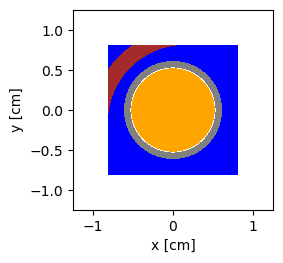

In [88]:
ul_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ul_corner_fuel_cell: 'orange', ul_corner_gap_cell: 'white', ul_corner_clad_cell: 'grey', ul_sleave_cell:'brown', ul_inner_helium_cell: 'blue', ul_sleave_helium_cell: 'blue', ul_sleave_ver_helium_cell: 'blue', ul_opposite_helium_cell: 'blue', ul_sleave_hor_helium_cell: 'blue'})

In [89]:
ll_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='ll Corner Cell: Fuel OR')
ll_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='ll Corner Cell: Clad IR')
ll_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='ll Corner Cell: Clad OR')

ll_corner_fuel_cell = openmc.Cell(name='ll fuel')
ll_corner_fuel_cell.fill = spent_fuel
ll_corner_fuel_cell.region = -ll_corner_fuel_or 

ll_corner_gap_cell = openmc.Cell(name='ll air gap')
ll_corner_gap_cell.region = -ll_corner_clad_ir & +ll_corner_fuel_or

ll_corner_clad_cell = openmc.Cell(name='ll clad')
ll_corner_clad_cell.fill = zircaloy
ll_corner_clad_cell.region = +ll_corner_clad_ir & -ll_corner_clad_or

ll_sleave_ir = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius)
ll_sleave_or = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius+sleave_thickness)

ll_sleave_hor_bound = openmc.XPlane(x0=-pitch/2+sleave_inner_radius+margin)
ll_sleave_ver_bound = openmc.YPlane(y0=-pitch/2+sleave_inner_radius-margin)

ll_sleave_cell = openmc.Cell(name='ul sleave cell')
ll_sleave_cell.region = -ll_sleave_or & +ll_sleave_ir & -ll_sleave_hor_bound & -ll_sleave_ver_bound & pin_cell_box
ll_sleave_cell.fill = zircaloy

ll_sleave_helium_cell = openmc.Cell(name='ul sleave helium')
ll_sleave_helium_cell.region = pin_cell_box & -ll_sleave_hor_bound & -ll_sleave_ver_bound & +ll_sleave_or
ll_sleave_helium_cell.fill = helium

ll_sleave_ver_helium_cell = openmc.Cell(name='ul vertically-equivalent sleave helium')
ll_sleave_ver_helium_cell.region = pin_cell_box & +ll_sleave_hor_bound & -ll_sleave_ver_bound & +ll_sleave_ir
ll_sleave_ver_helium_cell.fill = helium 

ll_opposite_helium_cell = openmc.Cell(name='ul opposite helium')
ll_opposite_helium_cell.region = pin_cell_box & +ll_sleave_hor_bound & +ll_sleave_ver_bound & +ll_sleave_ir
ll_opposite_helium_cell.fill = helium 

ll_sleave_hor_helium_cell = openmc.Cell(name='ul horizontally-equivalent sleave helium')
ll_sleave_hor_helium_cell.region = pin_cell_box & -ll_sleave_hor_bound & +ll_sleave_ver_bound & +ll_sleave_ir
ll_sleave_hor_helium_cell.fill = helium 

ll_inner_helium_cell = openmc.Cell(name='ul inner helium cell')
ll_inner_helium_cell.region = pin_cell_box & -ll_sleave_ir & +ll_corner_clad_or
ll_inner_helium_cell.fill = helium

ll_corner_pin_universe = openmc.Universe(cells=[ll_corner_fuel_cell, ll_corner_gap_cell, ll_corner_clad_cell, ll_sleave_cell, ll_inner_helium_cell, ll_sleave_helium_cell, ll_sleave_ver_helium_cell, ll_opposite_helium_cell, ll_sleave_hor_helium_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

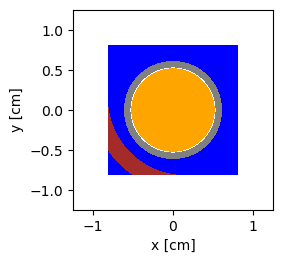

In [90]:
ll_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ll_corner_fuel_cell: 'orange', ll_corner_gap_cell: 'white', ll_corner_clad_cell: 'grey', ll_sleave_cell:'brown', ll_inner_helium_cell: 'blue', ll_sleave_helium_cell: 'blue', ll_sleave_ver_helium_cell: 'blue', ll_opposite_helium_cell: 'blue', ll_sleave_hor_helium_cell: 'blue'})

In [91]:
lr_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='lr Corner Cell: Fuel OR')
lr_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='lr Corner Cell: Clad IR')
lr_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='lr Corner Cell: Clad OR')

lr_corner_fuel_cell = openmc.Cell(name='lr fuel')
lr_corner_fuel_cell.fill = spent_fuel
lr_corner_fuel_cell.region = -lr_corner_fuel_or 

lr_corner_gap_cell = openmc.Cell(name='lr air gap')
lr_corner_gap_cell.region = -lr_corner_clad_ir & +lr_corner_fuel_or

lr_corner_clad_cell = openmc.Cell(name='lr clad')
lr_corner_clad_cell.fill = zircaloy
lr_corner_clad_cell.region = +lr_corner_clad_ir & -lr_corner_clad_or

lr_sleave_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius)
lr_sleave_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius+sleave_thickness)

lr_sleave_hor_bound = openmc.XPlane(x0=pitch/2 - sleave_inner_radius - margin)
lr_sleave_ver_bound = openmc.YPlane(y0=-pitch/2 + sleave_inner_radius - margin)

lr_sleave_cell = openmc.Cell(name='ur sleave cell')
lr_sleave_cell.region = -lr_sleave_or & +lr_sleave_ir & +lr_sleave_hor_bound & -lr_sleave_ver_bound & pin_cell_box
lr_sleave_cell.fill = zircaloy

lr_sleave_helium_cell = openmc.Cell(name='ur sleave helium')
lr_sleave_helium_cell.region = pin_cell_box & +lr_sleave_hor_bound & -lr_sleave_ver_bound & +lr_sleave_or
lr_sleave_helium_cell.fill = helium

lr_sleave_ver_helium_cell = openmc.Cell(name='ur vertically-equivalent sleave helium')
lr_sleave_ver_helium_cell.region = pin_cell_box & -lr_sleave_hor_bound & -lr_sleave_ver_bound & +lr_sleave_ir
lr_sleave_ver_helium_cell.fill = helium 

lr_opposite_helium_cell = openmc.Cell(name='ur opposite helium')
lr_opposite_helium_cell.region = pin_cell_box & -lr_sleave_hor_bound & +lr_sleave_ver_bound & +lr_sleave_ir
lr_opposite_helium_cell.fill = helium 

lr_sleave_hor_helium_cell = openmc.Cell(name='ur horizontally-equivalent sleave helium')
lr_sleave_hor_helium_cell.region = pin_cell_box & +lr_sleave_hor_bound & +lr_sleave_ver_bound & +lr_sleave_ir
lr_sleave_hor_helium_cell.fill = helium 

lr_inner_helium_cell = openmc.Cell(name='ur inner helium cell')
lr_inner_helium_cell.region = pin_cell_box & -lr_sleave_ir & +lr_corner_clad_or
lr_inner_helium_cell.fill = helium

lr_corner_pin_universe = openmc.Universe(cells=[lr_corner_fuel_cell, lr_corner_gap_cell, lr_corner_clad_cell, lr_sleave_cell, lr_inner_helium_cell, lr_sleave_helium_cell, lr_sleave_ver_helium_cell, lr_opposite_helium_cell, lr_sleave_hor_helium_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

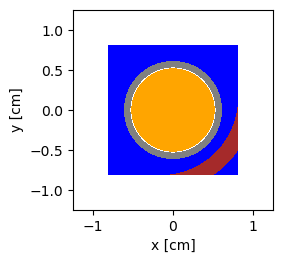

In [92]:
lr_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {lr_corner_fuel_cell: 'orange', lr_corner_gap_cell: 'white', lr_corner_clad_cell: 'grey', lr_sleave_cell:'brown', lr_inner_helium_cell: 'blue', lr_sleave_helium_cell: 'blue', lr_sleave_ver_helium_cell: 'blue', lr_opposite_helium_cell: 'blue', lr_sleave_hor_helium_cell: 'blue'})

In [93]:
import openmc

quarter_pitch = pitch * 8

assembly = openmc.RectLattice(name='Quarter Assembly')
assembly.pitch = (pitch, pitch)
assembly.lower_left = [-quarter_pitch/2, -quarter_pitch/2]

assembly.universes = [
                      [ul_corner_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, ur_corner_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, helium_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, helium_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [ll_corner_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, lr_corner_pin_universe]
]

# Define x and y planes for assembly region
x_min_assembly = openmc.XPlane(x0=-quarter_pitch / 2)
x_max_assembly = openmc.XPlane(x0=quarter_pitch / 2)
y_min_assembly = openmc.YPlane(y0=-quarter_pitch / 2)
y_max_assembly = openmc.YPlane(y0=quarter_pitch / 2)

# Create assembly region using planes
assembly_region = +x_min_assembly & -x_max_assembly & +y_min_assembly & -y_max_assembly
assembly_cell = openmc.Cell(name='quarter assembly cell', fill=assembly, region=assembly_region)

# Define x and y planes for assembly sleeve with added thickness
x_min_sleave = openmc.XPlane(x0=-(quarter_pitch + 2*sleave_thickness) / 2)
x_max_sleave = openmc.XPlane(x0=(quarter_pitch + 2*sleave_thickness) / 2)
y_min_sleave = openmc.YPlane(y0=-(quarter_pitch + 2*sleave_thickness) / 2)
y_max_sleave = openmc.YPlane(y0=(quarter_pitch + 2*sleave_thickness) / 2)

# Create assembly sleeve region using planes and exclude assembly region
assembly_sleave = openmc.Cell(name='quarter assembly sleave')
assembly_sleave.region = +x_min_sleave & -x_max_sleave & +y_min_sleave & -y_max_sleave & ~assembly_cell.region 
assembly_sleave.fill = zircaloy

# Define x and y planes for outer helium with added thickness and reflective boundary
x_min_helium = openmc.XPlane(x0=-(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')
x_max_helium = openmc.XPlane(x0=(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')
y_min_helium = openmc.YPlane(y0=-(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')
y_max_helium = openmc.YPlane(y0=(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')

# Create outer helium region using planes and exclude assembly and sleeve regions
assembly_outer_helium = openmc.Cell(name='assembly outer helium')
assembly_outer_helium.region = +x_min_helium & -x_max_helium & +y_min_helium & -y_max_helium & ~assembly_sleave.region & ~assembly_cell.region
assembly_outer_helium.fill = helium

quarter_assembly_universe = openmc.Universe(cells=[assembly_cell, assembly_sleave, assembly_outer_helium])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

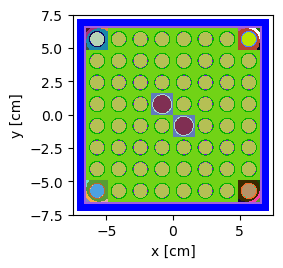

In [94]:
quarter_assembly_universe.plot(width=(15,15), colors={assembly_outer_helium: 'blue'})

In [95]:
geom = openmc.Geometry(quarter_assembly_universe)
geom.export_to_xml()

In [96]:
import openmc

# OpenMC simulation parameters

point = openmc.stats.Point((0, 0, 0))
src = openmc.IndependentSource(space=point)  # Use IndependentSource
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.export_to_xml()

In [97]:
openmc.run()

[sebastian-TUF-Gaming-FX505GT:118985] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.sebastian-TUF-Gaming-FX505GT.1000/jf.0/1489174528/shared_mem_cuda_pool.sebastian-TUF-Gaming-FX505GT could be created.
[sebastian-TUF-Gaming-FX505GT:118985] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%

RuntimeError: Maximum number of lost particles has been reached. -------------------------------------------------------------------------- MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD Proc: [[22723,0],0] Errorcode: -1 NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes. You may or may not see output from other processes, depending on exactly when Open MPI kills them. -------------------------------------------------------------------------- ERROR: Maximum number of lost particles has been reached. -------------------------------------------------------------------------- MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD Proc: [[22723,0],0] Errorcode: -1 NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes. You may or may not see output from other processes, depending on exactly when Open MPI kills them. --------------------------------------------------------------------------